In [ ]:
from math import sqrt, sin, cos, exp
from numpy.linalg import norm, solve
from scipy.optimize import newton, bisect

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

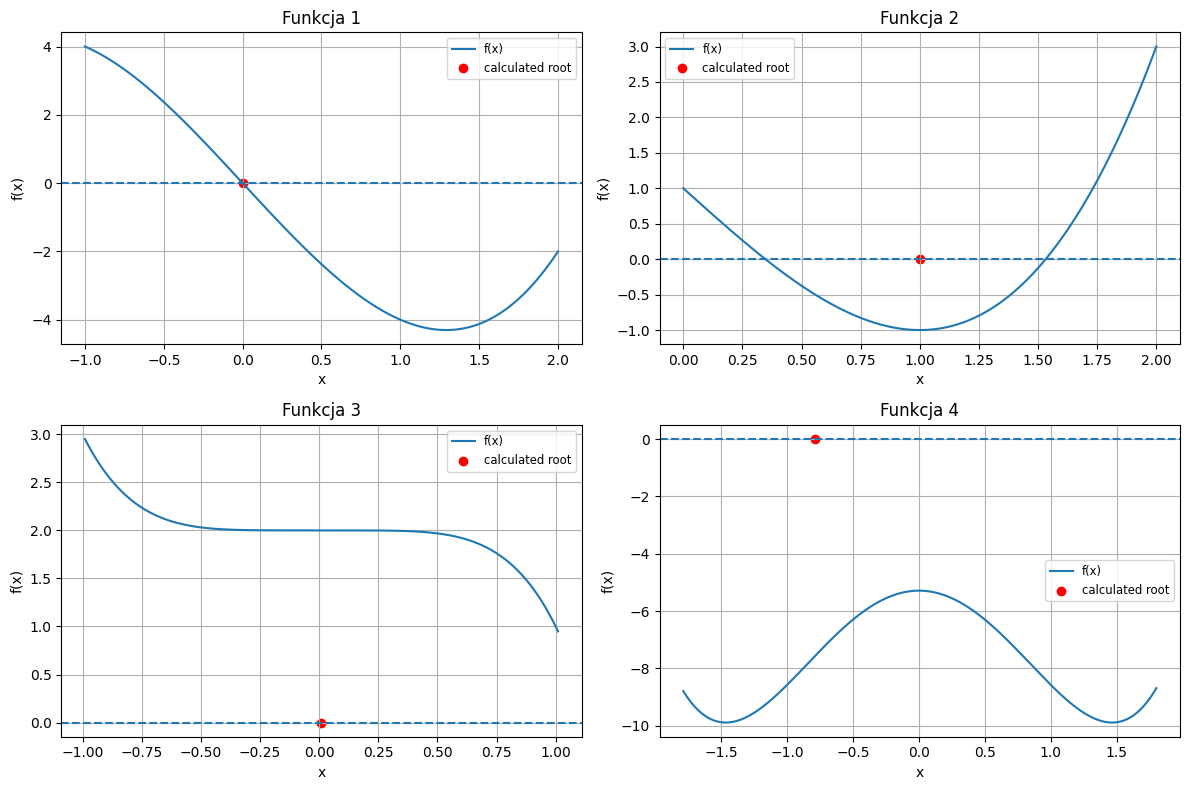

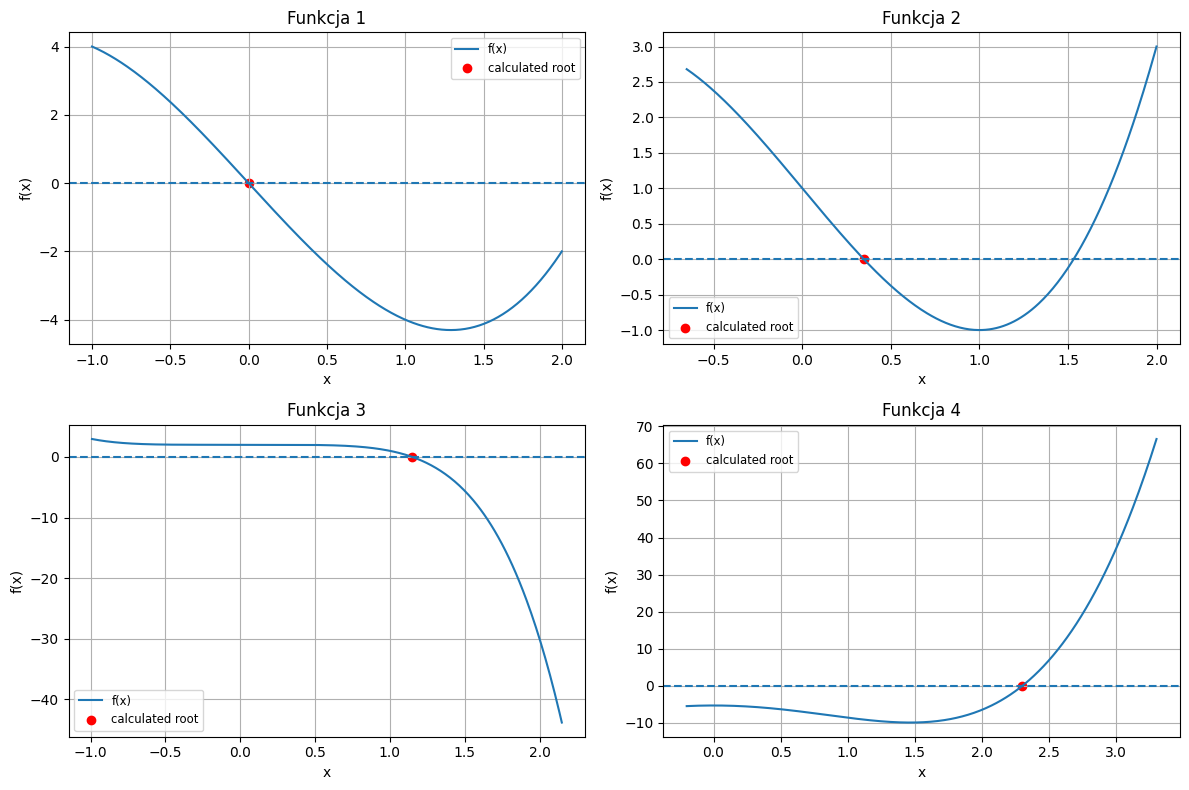

In [ ]:
# task 1

def plot_roots(data, roots):
    """
    Rysuje wszystkie wykresy funkcji w gridzie 2x2
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    for ax, (f, x0, f_desc), root in zip(axes, data, roots):
        # obliczamy jaki zakres mamy objąć
        x_min = min(x0, root) - 1
        x_max = max(x0, root) + 1
        x = np.linspace(x_min, x_max, 400)
        y = f(x)
        
        ax.plot(x, y, label='f(x) = '+f_desc)
        ax.axhline(0, linestyle='--')
        ax.scatter([root], [0], marker='o', label=f'calculated root', color = 'red')
        ax.scatter([x0], [f(x0)], marker='o', label=f'x0={x0:.2f}', color = 'green')

        ax.set_title(f'Funkcja {data.index((f, x0, f_desc))+1}')
        ax.set_xlabel('x')
        ax.set_ylabel('f(x)')
        ax.grid(True)
        ax.legend(loc='best', fontsize='small')
    
    plt.tight_layout()
    plt.show()

f_a = lambda x: x**3 - 5*x 
f_b = lambda x: x**3 - 3*x + 1
f_c = lambda x: 2 - x**5
f_d = lambda x: x**4 - 4.29 * x**2 - 5.29

data = [(f_a, 1, "x^3 - 5*x"), (f_b, 1, "x^3 - 3*x + 1"), (f_c, 0.01, "2 - x^5"), (f_d, 0.8, "x^4 - 4.29 * x^2 - 5.29")] # zbieramy funkcje i x0 razem
newton_roots = [newton(f, x0) for f, x0, _ in data]
# dla każdej funkcji dajemy przykładowe przedziały początkowe
bisect_roots = [bisect(f_a, -1, 1), bisect(f_b, -1, 1),
                 bisect(f_c, 0, 2), bisect(f_d, 2, 3)]

plot_roots(data, newton_roots)
plot_roots(data, bisect_roots)


Schemat phi1:
                                                                           x_k                                                                   epsilon_k      r_exp
k                                                                                                                                                                    
1                                                                   3.66666667                                                                  1.66666667        NaN
2                                                                   5.14814815                                                                  3.14814815        NaN
3                                                                   9.50114312                                                                  7.50114312 1.36518297
4                                                                  30.75724019                                                                 28.75724019 

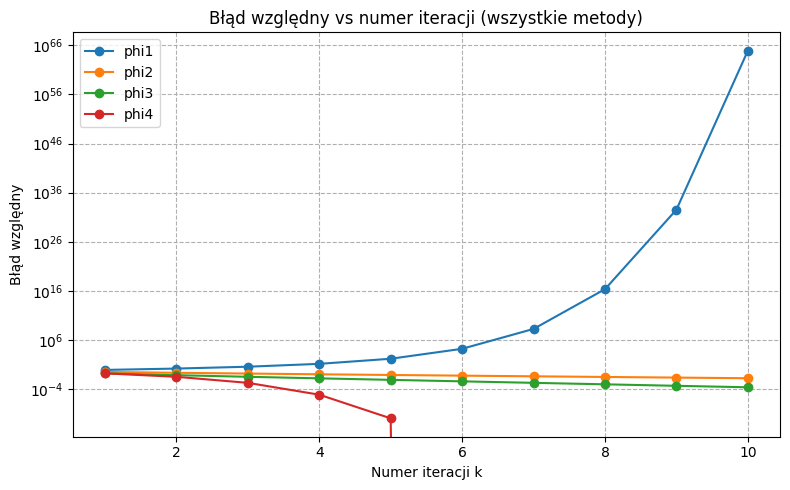

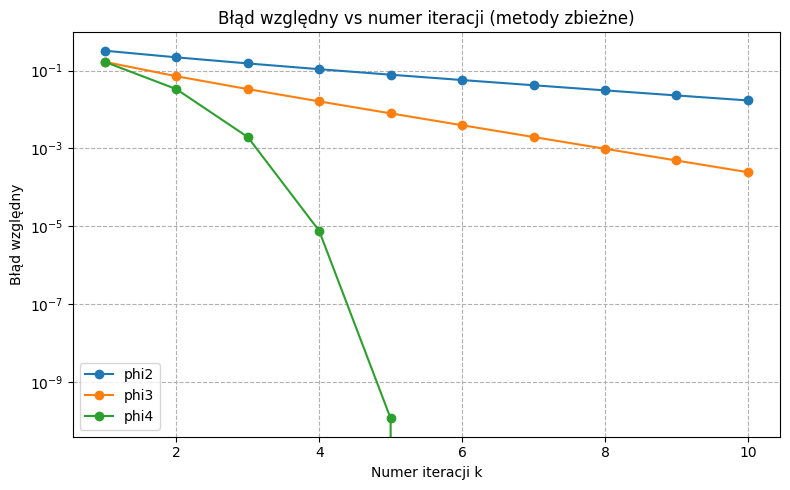

In [ ]:
# task 2

def phi1(x): return (x**2 + 2) / 3
def phi2(x): return np.sqrt(3*x - 2)
def phi3(x): return 3 - 2/x
def phi4(x): return (x**2 - 2) / (2*x - 3)

phi_funcs = {
    "phi1": phi1,
    "phi2": phi2,
    "phi3": phi3,
    "phi4": phi4
}

alpha = 2.0      # rzeczywisty pierwiastek
x0 = 3.0          # punkt startowy
n_iter = 10       # liczba iteracji

for name, phi in phi_funcs.items():
    xs = [x0]
    eps = []
    # wykonanie iteracji
    for _ in range(n_iter):
        x_new = phi(xs[-1])
        xs.append(x_new)
        eps.append(abs(x_new - alpha))
    
    # obliczenie eksperymentalnego rzędu zbieżności
    r = [np.nan, np.nan]  # brak dla k=1,2 (potrzebne przynajmniej 3 wartości do wzoru)
    for k in range(2, len(eps)):
        try:
            num = np.log(eps[k-1] / eps[k])
            den = np.log(eps[k-2] / eps[k-1])
            r.append(num / den)
        except (ZeroDivisionError, FloatingPointError):
            r.append(np.nan)
    
    # przygotowanie tabeli
    df = pd.DataFrame({
        "k": np.arange(1, n_iter+1),
        "x_k": xs[1:],
        "epsilon_k": eps,
        "r_exp": r
    }).set_index("k")
    
    print(f"\nSchemat {name}:")
    print(df.to_string(float_format='%.8f'))

# zbieranie błędów względnych
rel_errors = {}
for name, phi in phi_funcs.items():
    x = x0
    errors = []
    for k in range(n_iter):
        x = phi(x)
        errors.append(abs(x - alpha) / abs(alpha))
    rel_errors[name] = errors

# c) - wspólny wykres wszystkich metod
plt.figure(figsize=(8, 5))
for name, errors in rel_errors.items():
    plt.semilogy(range(1, n_iter+1), errors, marker='o', label=name)
plt.title("Błąd względny vs numer iteracji (wszystkie metody)")
plt.xlabel("Numer iteracji k")
plt.ylabel("Błąd względny")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()

# c) - wykres tylko metod zbieżnych (phi2, phi3, phi4)
plt.figure(figsize=(8, 5))
for name in ["phi2", "phi3", "phi4"]:
    plt.semilogy(range(1, n_iter+1), rel_errors[name], marker='o', label=name)
plt.title("Błąd względny vs numer iteracji (metody zbieżne)")
plt.xlabel("Numer iteracji k")
plt.ylabel("Błąd względny")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Task 3

def newton_method(f, df, x0, tol=1e-10, max_iter=100, ans=None, bits=2**(-24)):
    """
    Implementacja metody Newtona
    f: funkcja, której pierwiastek szukamy
    df: pochodna funkcji f
    x0: przybliżenie początkowe
    tol: tolerancja błędu
    max_iter: maksymalna liczba iteracji
    ans: znane x
    bits: szukana precyzja względem znanego x
    """
    x = x0
    iterations = []
    errors = []
    
    for i in range(max_iter):
        if ans is not None and abs(x-ans) < bits:
            break
        f_value = f(x)
        df_value = df(x)
        
        # Jeśli pochodna jest bliska zeru, przerwij
        if abs(df_value) < 1e-14:
            break
            
        # Krok metody Newtona
        x_new = x - f_value / df_value
        
        # Zapisz iterację i błąd (względny)
        iterations.append(i)
        # Ponieważ nie znamy dokładnego rozwiązania, używamy różnicy między kolejnymi przybliżeniami
        error = abs(x_new - x)
        errors.append(error)
        
        # Sprawdź warunek stopu
        if error < tol:
            break
            
        x = x_new
    
    return x, iterations, errors

def plot_newton_convergence(iterations, errors, title):
    """
    Funkcja do tworzenia wykresu zbieżności
    """
    plt.figure(figsize=(10, 6))
    
    # Wykres liniowy
    plt.subplot(1, 2, 1)
    plt.plot(iterations, errors, 'o-', markersize=6)
    plt.yscale('log')
    plt.xlabel('Iteracja')
    plt.ylabel('Błąd |x_{n+1} - x_n|')
    plt.title(f'Zbieżność metody Newtona - {title}')
    plt.grid(True)
    
    # Wykres zbieżności logarytmicznej
    plt.subplot(1, 2, 2)
    if len(iterations) > 1:
        plt.semilogy(iterations[:-1], [errors[i+1]/errors[i]**2 for i in range(len(errors)-1)], 'o-', markersize=6)
        plt.xlabel('Iteracja')
        plt.ylabel('|e_{n+1}|/|e_n|^2')
        plt.title('Kwadratowa zbieżność')
        plt.grid(True)
        plt.axhline(y=0.5, color='r', linestyle='-', alpha=0.3)
    
    # plt.tight_layout()
    return plt

# (a) x^3 - 2x - 5 = 0
f1 = lambda x: x**3 - 2*x - 5
df1 = lambda x: 3*x**2 - 2

# (b) e^(-x) = x
f2 = lambda x: exp(-x) - x
df2 = lambda x: -exp(-x) - 1

# (c) x*sin(x) = 1
f3 = lambda x: x*sin(x) - 1
df3 = lambda x: sin(x) + x*cos(x)

# Przybliżenia początkowe dla każdego równania
x0_a = 2.0
x0_b = 0.5
x0_c = 1.0

solution_a, iterations_a, errors_a = newton_method(f1, df1, x0_a)
solution_b, iterations_b, errors_b = newton_method(f2, df2, x0_b)
solution_c, iterations_c, errors_c = newton_method(f3, df3, x0_c)

plt_a = plot_newton_convergence(iterations_a, errors_a, "x³ - 2x - 5 = 0")
plt_b = plot_newton_convergence(iterations_b, errors_b, "e⁻ˣ = x")
plt_c = plot_newton_convergence(iterations_c, errors_c, "x·sin(x) = 1")

print("(a) x³ - 2x - 5 = 0:")
print(f"  Przybliżony pierwiastek: {solution_a}")
print(f"  Liczba iteracji: {len(iterations_a)}")
print(f"  Błąd w ostatniej iteracji: {errors_a[-1]}")

print("\n(b) e⁻ˣ = x:")
print(f"  Przybliżony pierwiastek: {solution_b}")
print(f"  Liczba iteracji: {len(iterations_b)}")
print(f"  Błąd w ostatniej iteracji: {errors_b[-1]}")

print("\n(c) x·sin(x) = 1:")
print(f"  Przybliżony pierwiastek: {solution_c}")
print(f"  Liczba iteracji: {len(iterations_c)}")
print(f"  Błąd w ostatniej iteracji: {errors_c[-1]}")

initial_error = 2**(-4) # Błąd początkowy odpowiadający 4-bitowej dokładności

error_ratio = 0.5

iters_24bits = len(newton_method(f1, df1, x0_a, ans=solution_a, bits=2**(-24))[1])
iters_53bits = len(newton_method(f1, df1, x0_a, ans=solution_a, bits=2**(-53))[1])

print("\nWymagana liczba iteracji od 4-bitowej dokładności dla (a):")
print(f"  Do osiągnięcia 24-bitowej dokładności: {int(iters_24bits)}")
print(f"  Do osiągnięcia 53-bitowej dokładności: {int(iters_53bits)}")

precision_bits = range(4, 60)
iterations_needed = [int(len(newton_method(f1, df1, x0_a, ans=solution_a, bits=2**(-bits))[1])) for bits in precision_bits]

plt.figure(figsize=(10, 6))
plt.plot(precision_bits, iterations_needed, 'o-', markersize=4)
plt.axhline(y=int(iters_24bits), color='r', linestyle='--', label=f'24 bity ({int(iters_24bits)} iteracji)')
plt.axhline(y=int(iters_53bits), color='g', linestyle='--', label=f'53 bity ({int(iters_53bits)} iteracji)')
plt.axvline(x=24, color='r', linestyle=':', alpha=0.5)
plt.axvline(x=53, color='g', linestyle=':', alpha=0.5)
plt.xlabel('Wymagana dokładność [bity]')
plt.ylabel('Liczba iteracji')
plt.title('Liczba iteracji potrzebna do osiągnięcia danej dokładności bitowej dla (a)')
plt.grid(True)
plt.legend()

plt.show()

In [ ]:
# Task 4

def newton_system(F, J, x0, tol=1e-10, max_iter=100):
    """
    Implementacja metody Newtona dla układu równań nieliniowych
    F: funkcja wektorowa reprezentująca układ równań F(x) = 0
    J: funkcja zwracająca macierz jakobianową układu
    x0: przybliżenie początkowe (wektor)
    tol: tolerancja błędu
    max_iter: maksymalna liczba iteracji
    """
    x = np.array(x0, dtype=float)
    iterations = []
    errors = []
    x_values = [x.copy()]
    
    for i in range(max_iter):
        # Oblicz wartość funkcji F i macierzy jakobianowej J w punkcie x
        F_value = F(x)
        J_value = J(x)
        
        # Rozwiąż układ równań liniowych J(x) * delta = -F(x)
        try:
            delta = solve(J_value, -F_value)
        except np.linalg.LinAlgError:
            print(f"Macierz jakobianowa jest osobliwa w iteracji {i}")
            break
        
        # Aktualizuj x
        x_new = x + delta
        
        # Zapisz iterację i błąd
        iterations.append(i)
        error = norm(delta)
        errors.append(error)
        x_values.append(x_new.copy())
        
        # Aktualizuj x
        x = x_new
        
        # Sprawdź warunek stopu
        if error < tol:
            break
    
    return x, iterations, errors, x_values

# Definicja układu równań:
# F1(x1, x2) = x1^2 + x2^2 - 1 = 0
# F2(x1, x2) = x1^2 - x2 = 0

def F(x):
    """Funkcja układu równań F(x) = 0"""
    x1, x2 = x
    return np.array([
        x1**2 + x2**2 - 1,
        x1**2 - x2
    ])

def J(x):
    """Macierz jakobianowa układu"""
    x1, x2 = x
    return np.array([
        [2*x1, 2*x2],
        [2*x1, -1]
    ])

# Dokładne rozwiązania
exact_solution1 = np.array([sqrt(sqrt(5)/2 - 1/2), sqrt(5)/2 - 1/2])
exact_solution2 = np.array([-sqrt(sqrt(5)/2 - 1/2), sqrt(5)/2 - 1/2])

print("Dokładne rozwiązanie 1:")
print(f"x1 = {exact_solution1[0]}")
print(f"x2 = {exact_solution1[1]}")

print("\nDokładne rozwiązanie 2:")
print(f"x1 = {exact_solution2[0]}")
print(f"x2 = {exact_solution2[1]}")

# Weryfikacja dokładnych rozwiązań
print("\nWeryfikacja dokładnych rozwiązań:")
print(f"F(rozwiązanie 1) = {F(exact_solution1)}")
print(f"F(rozwiązanie 2) = {F(exact_solution2)}")

# Przybliżenia początkowe - wybierzmy kilka różnych
initial_guesses = [
    [0.5, 0.5],  # Blisko rozwiązania 1
    [-0.5, 0.5], # Blisko rozwiązania 2
    [0.7, 0.3],
    [-0.7, 0.3]
]

results = []

for idx, x0 in enumerate(initial_guesses):
    print(f"\n\nPrzybliżenie początkowe {idx+1}: x0 = {x0}")
    
    solution, iterations, errors, x_values = newton_system(F, J, x0)
    
    print(f"Znalezione rozwiązanie: x = {solution}")
    print(f"Liczba iteracji: {len(iterations)}")
    print(f"Błąd w ostatniej iteracji: {errors[-1]}")
    
    # Sprawdź, które dokładne rozwiązanie jest bliższe znalezionemu
    dist1 = norm(solution - exact_solution1)
    dist2 = norm(solution - exact_solution2)
    
    if dist1 < dist2:
        exact = exact_solution1
        print("Najbliższe dokładne rozwiązanie: rozwiązanie 1")
    else:
        exact = exact_solution2
        print("Najbliższe dokładne rozwiązanie: rozwiązanie 2")
    
    # Oblicz błąd względny
    relative_error = norm(solution - exact) / norm(exact)
    print(f"Błąd względny: {relative_error}")
    
    results.append({
        'initial_guess': x0,
        'solution': solution,
        'iterations': len(iterations),
        'errors': errors,
        'x_values': x_values,
        'closest_exact': exact,
        'relative_error': relative_error
    })

# Wizualizacja zbieżności
plt.figure(figsize=(12, 6))

for idx, result in enumerate(results):
    plt.subplot(1, 2, 1)
    plt.semilogy(range(len(result['errors'])), result['errors'], 'o-', label=f'start {idx+1}: {result["initial_guess"]}')
    plt.xlabel('Iteracja')
    plt.ylabel('Błąd |x_{n+1} - x_n|')
    plt.grid(True)
    plt.legend()
    plt.title('Zbieżność metody Newtona')

# Wizualizacja okręgu i paraboli oraz ścieżek zbieżności
plt.subplot(1, 2, 2)

# Rysuj okrąg x1^2 + x2^2 = 1
theta = np.linspace(0, 2*np.pi, 100)
circle_x = np.cos(theta)
circle_y = np.sin(theta)
plt.plot(circle_x, circle_y, 'b-', label='x1^2 + x2^2 = 1')

# Rysuj parabolę x2 = x1^2
x1_vals = np.linspace(-1, 1, 100)
x2_vals = x1_vals**2
plt.plot(x1_vals, x2_vals, 'r-', label='x2 = x1^2')

# Zaznacz dokładne rozwiązania
plt.plot(exact_solution1[0], exact_solution1[1], 'go', markersize=8, label='Dokładne rozwiązanie 1')
plt.plot(exact_solution2[0], exact_solution2[1], 'mo', markersize=8, label='Dokładne rozwiązanie 2')

# Rysuj ścieżki zbieżności
for idx, result in enumerate(results):
    x_values = result['x_values']
    xs = [x[0] for x in x_values]
    ys = [x[1] for x in x_values]
    plt.plot(xs, ys, 'o-', markersize=4, label=f'Ścieżka {idx+1}')
    plt.plot(xs[0], ys[0], 'kx', markersize=6)  # Zaznacz punkt startowy

plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)
plt.legend()
plt.title('Geometryczna interpretacja zbieżności')
plt.axis('equal')

plt.tight_layout()

# Sprawdźmy zbieżność do obu rozwiązań ze wspólnego punktu początkowego
x0_balanced = [0.1, 0.5]  # Punkt, z którego metoda może zbiegać do różnych rozwiązań

# Dodajmy małe zakłócenie
epsilon = 1e-5
x0_plus = [x0_balanced[0] + epsilon, x0_balanced[1]]
x0_minus = [x0_balanced[0] - epsilon, x0_balanced[1]]

print("\n\nBadanie wrażliwości na małe zakłócenia punktu początkowego:")
print(f"Punkt bazowy: {x0_balanced}")

solutions_sensitivity = []

for i, x0 in enumerate([x0_balanced, x0_plus, x0_minus]):
    print(f"\nPrzybliżenie początkowe: x0 = {x0}")
    
    solution, iterations, errors, x_values = newton_system(F, J, x0)
    
    print(f"Znalezione rozwiązanie: x = {solution}")
    dist1 = norm(solution - exact_solution1)
    dist2 = norm(solution - exact_solution2)
    
    if dist1 < dist2:
        print("Zbiegło do: rozwiązanie 1")
        exact = exact_solution1
    else:
        print("Zbiegło do: rozwiązanie 2")
        exact = exact_solution2
    
    relative_error = norm(solution - exact) / norm(exact)
    print(f"Błąd względny: {relative_error}")
    
    solutions_sensitivity.append({
        'initial_guess': x0,
        'solution': solution,
        'iterations': len(iterations),
        'x_values': x_values,
        'closest_exact': exact
    })

plt.tight_layout()

# Podsumowanie
print("\n\nPodsumowanie:")
print("1. Metoda Newtona dla układu równań nieliniowych zbiegła do rozwiązań analitycznych.")
print(f"2. Dokładne rozwiązania: ({exact_solution1[0]:.10f}, {exact_solution1[1]:.10f}) i ({exact_solution2[0]:.10f}, {exact_solution2[1]:.10f})")
print(f"3. Typowy błąd względny znalezionego rozwiązania: {results[0]['relative_error']:.10e}")
print("4. Wykazano kwadratową zbieżność metody Newtona.")
print("5. Zbadano wrażliwość metody na zakłócenia punktu początkowego.")

plt.show()